# Baseline
---

Vamos a construir un modelo muy sencillo para saber qué es lo peor que podemos hacer, en general esta es una tarea muy importante que queremos que repitan en sus proyectos de machine learning. ¿Por qué?

* Navaja de Ockam: “Cuando se ofrecen dos o más explicaciones de un fenómeno, es preferible la explicación completa más simple; es decir, no deben multiplicarse las entidades sin necesidad.” ¿Para qué desarrollar un modelo super complejo si capaz es peor o casi igual que uno muy sencillo?
* Nos sirve para saber si estamos usando bien los modelos más complejos, si su score nos da peor al baseline probablemente se deba a un error de código.
* Nos sirve para rápidamente saber que tan complejo es un problema.
* Los modelos simples son fáciles de entender.
* Utilice todas las columnas del dataset (exceptuando columnas que no tenga sentido usar para predecir) con algún encoding donde sea necesario para entrenar una regresión logística, utilizando búsqueda de hiperparametros y garantizando la reproducibilidad de los resultados cuando el notebook corriera varias veces. Conteste las preguntas:

* ¿Cuál es el mejor score de validación obtenido? (¿Cómo conviene obtener el dataset para validar?)
    * Al predecir con este modelo para test, ¿Cúal es el score obtenido? (guardar el csv con predicciones para entregarlo después)
    * ¿Qué features son los más importantes para predecir con el mejor modelo? Graficar.

In [1]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression
from category_encoders import BinaryEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
df = pd.read_csv('data/secondary_data.csv', sep=';')
df

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,p,15.26,x,g,o,f,e,NaN,w,16.95,...,s,y,w,u,w,t,g,NaN,d,w
1,p,16.60,x,g,o,f,e,NaN,w,17.99,...,s,y,w,u,w,t,g,NaN,d,u
2,p,14.07,x,g,o,f,e,NaN,w,17.80,...,s,y,w,u,w,t,g,NaN,d,w
3,p,14.17,f,h,e,f,e,NaN,w,15.77,...,s,y,w,u,w,t,p,NaN,d,w
4,p,14.64,x,h,o,f,e,NaN,w,16.53,...,s,y,w,u,w,t,p,NaN,d,w
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61064,p,1.18,s,s,y,f,f,f,f,3.93,...,NaN,NaN,y,NaN,NaN,f,f,NaN,d,a
61065,p,1.27,f,s,y,f,f,f,f,3.18,...,NaN,NaN,y,NaN,NaN,f,f,NaN,d,a
61066,p,1.27,s,s,y,f,f,f,f,3.86,...,NaN,NaN,y,NaN,NaN,f,f,NaN,d,u
61067,p,1.24,f,s,y,f,f,f,f,3.56,...,NaN,NaN,y,NaN,NaN,f,f,NaN,d,u


### Set de Validación y Test

Ambos sets se pueden obtener de forma aleatoria ya que no hay una relación de orden o tiempo entre los datos.

In [4]:
# Separo los datos en train, test y validación.
X = df.drop(['class'], axis=1).fillna('#')
y = df['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
X_test, X_validacion, y_test, y_validacion = train_test_split(X_test, y_test, test_size=0.5, random_state=123)
# 80% train, 10% test, 10% validación.
indice_test = X_test.index

In [6]:
# Separo las variables continuas.
continuas = ['cap-diameter','stem-height','stem-width']
continuas_train = X_train[continuas]
continuas_test = X_test[continuas]
continuas_validacion = X_validacion[continuas]

X_train.drop(continuas, axis=1, inplace=True)
X_test.drop(continuas, axis=1, inplace=True)
X_validacion.drop(continuas, axis=1, inplace=True)

# Encodeo las variables categoricas.
be = BinaryEncoder()
X_train = be.fit_transform(X_train)
X_test = be.transform(X_test)
X_validacion = be.transform(X_validacion)

# Encodeo la variable target.
ohe = OneHotEncoder(drop='first', sparse_output=False)
y_train = ohe.fit_transform(y_train.values.reshape(-1,1))[:,0]
y_test = ohe.transform(y_test.values.reshape(-1,1))[:,0]
y_validacion = ohe.transform(y_validacion.values.reshape(-1,1))[:,0]

# Escalo los datos.
scaler = StandardScaler()
conintuas_train = scaler.fit_transform(continuas_train)
continuas_test = scaler.transform(continuas_test)
continuas_validacion = scaler.transform(continuas_validacion)

# Junto todo en sus 3 datasets.
X_train = X_train.join(pd.DataFrame(conintuas_train, columns=continuas, index=X_train.index))
X_test = X_test.join(pd.DataFrame(continuas_test, columns=continuas, index=X_test.index))
X_validacion = X_validacion.join(pd.DataFrame(continuas_validacion, columns=continuas, index=X_validacion.index))

## Busqueda de Hiper-parametros

In [5]:
lr = LogisticRegression(max_iter=1000, random_state=123)

params = {
    'penalty': ['l2'],
    'C': [3.49, 3.50, 3.51, 3.52, 3.53],
}

gs = GridSearchCV(lr, param_grid=params, scoring='roc_auc')
gs.fit(X_train, y_train)

GridSearchCV(estimator=LogisticRegression(max_iter=1000, random_state=123),
             param_grid={'C': [3.49, 3.5, 3.51, 3.52, 3.53], 'penalty': ['l2']},
             scoring='roc_auc')

In [6]:
lr = gs.best_estimator_
gs.best_params_

{'C': 3.51, 'penalty': 'l2'}

## Auc Roc

In [7]:
preds_prob = lr.predict_proba(X_validacion)[:,-1]
print(f'Puntaje auc_roc en validación: {roc_auc_score(y_validacion, preds_prob)}')

Puntaje auc_roc en validación: 0.8689084401736551


In [8]:
preds_test = lr.predict_proba(X_test)[:,-1]
print(f'Puntaje auc_roc en test: {roc_auc_score(y_test, preds_test)}')

Puntaje auc_roc en test: 0.8604370876990848


## Matriz de Confusión

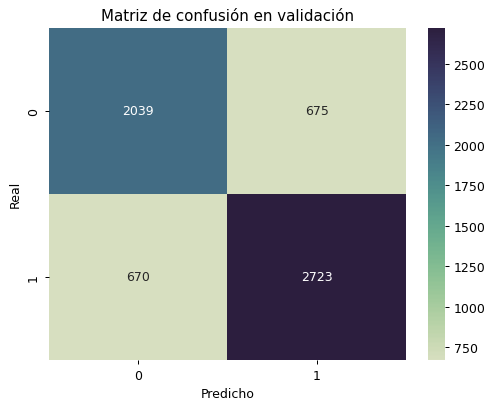

In [9]:
preds_bin = lr.predict(X_validacion)
cm = confusion_matrix(y_validacion, preds_bin)
plt.figure(dpi=90)
sns.heatmap(cm, annot=True, fmt='g', cmap=sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True))
plt.title('Matriz de confusión en validación')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

## Importancia de las Features

In [10]:
features = pd.DataFrame({'feature': X_train.columns, 'importance': lr.coef_[0]})
features.feature = features.feature.map(lambda x: x.split('_')[0])
features.importance = features.importance.map(abs)
features = features.groupby('feature').sum().reset_index()
features.head()

,feature,importance
0,cap-color,2.107310
1,cap-diameter,0.196181
2,cap-shape,1.087536
3,cap-surface,2.385005
4,does-bruise-or-bleed,0.701761


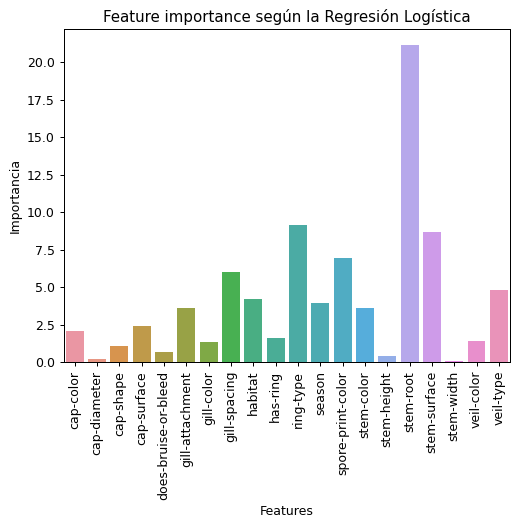

In [11]:
plt.figure(dpi=90)
sns.barplot(features, x='feature', y='importance')
plt.title('Feature importance según la Regresión Logística')
plt.xlabel('Features')
plt.ylabel('Importancia')
plt.xticks(rotation=90)
plt.show()

## Guardo las predicciones del modelo

In [15]:
predicciones = pd.DataFrame({'indice':X_test.index, 'prediccion':preds_test})
predicciones.to_csv('data/predicciones_baseline.csv', index=False)